In [69]:
%matplotlib inline
#! Required python packages: numpy, scipy, scikit-learn,
# matplotlib, seaborn, pandas, tqdm, ipywidgets
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns; sns.set()
import pandas as pd
from tqdm.notebook import tqdm

np.random.seed(17)
plt.rcParams['figure.figsize'] = [9.5, 6]

# Exercise 3 - ML & Generalization  (DD1420 HT23)

## Instructions

This Jupyter Notebook contains the exercises for DD1420 **Module 3 ML & Generalization**. There are a several problems in this exercise, each broken into numbered subproblems, *e.g.* 1.1.1. The points for each problem are marked *e.g.* $\color{red}{\text{(} x \text{ points)}}$. In total, the exercise is worth **23** points.

<br>

Students are allowed to work on this exercise in pairs. Make sure you have formed a group in Canvas with your partner. Each student is responsible for following the Code of Conduct. In particular (1) All members of a group are responsible for the group's work, (2) Every student shall honestly disclose any help received and sources used, and (3) Do not copy from other people's solutions. If you need assistance with the exercise, you are encouraged to post a question to the appropriate Discussion Topic or sign up for a help session.

<br>

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE" and delete `raise NotImplementedError()` once you have implemented the solution.

<br>

You should not import any libraries on top of the ones included in the assignment. Derivation questions can be answered using $\LaTeX$, or you may upload an image of your derivation. To do so in *Google Colab* simply create a text cell, click on the `insert image` icon, and upload an image to the notebook as we have demonstrated below.

<br>

**Submission** - once you have completed the exercise make sure everything runs as expected by going into `Runtime` -> `Restart and Run all`. Then download the notebook by clicking `file` -> `download` -> `download .ipynb`. Then **rename the file to include your name** (and **your partner's name** if you have one) as follows

<br>

`Ex??_LASTNAME_FIRSTNAME_and_LASTNAME_FIRSTNAME.ipynb`

<br>

where you replace `??` with the correct exercise number.

<br>

Good luck!

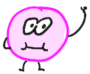

#Name
**Fill in your name and your partner's name below** (and name the `.ipynb` file correctly):

<br>

### Student 1 Kecheng Zhang

### Student 2 Ruimin Ma

# 3.1 Generalization of an Image Classifier  (13 points)


Let us start with a small experiment. We use the most famous dataset in the machine learning world -- [**MNIST**](https://en.wikipedia.org/wiki/MNIST_database). This full dataset contains 60,000 digits (0-9) handwritten written by high school students and employees of the United States Census Bureau. We will use a subset of MNIST with smaller image size. The goal is to classify each example according to the visible number. Because we are dealing with more than 2 classes (binary classification) we call this type of problem *multi-class* classification.

<br>

Note that any functions you write you can reuse unless explicitly instructed not to.


The images can be loaded as follows:

In [70]:
from sklearn.datasets import load_digits
data = load_digits()
imgs = data['images'] # shape (1797, 8, 8)
targets = data['target'] # shape (1797,)

A subset of the images look like this:

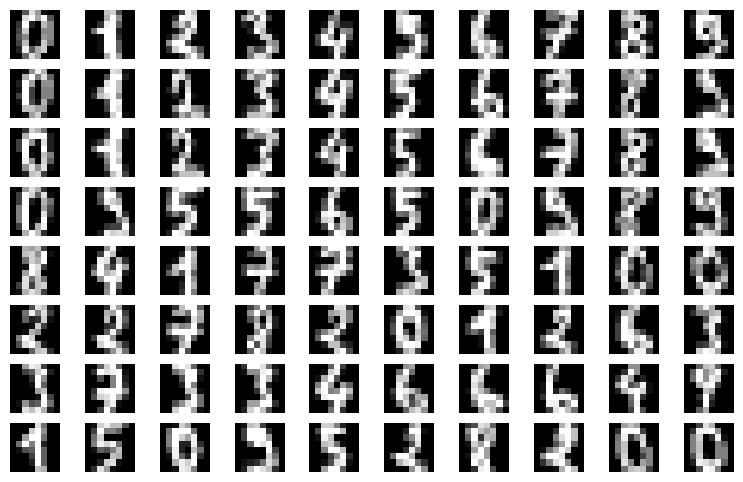

In [71]:
nrows, ncols = 8, 10
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex="all", sharey="all")
for j in range(ncols):
    for i in range(nrows):
        ax[i][j].imshow(imgs[ncols * i + j], cmap=plt.cm.gray)
        ax[i][j].axis('off')

For the purposes of this exercise we are going to flatten each $8 \times 8$ image into a **vector** of length $64$. Also, to keep the computational load reasonable we will only use `num_samples = 350`of the 1,797 images.

In [72]:
num_samples = 350
xs = np.reshape(imgs, newshape=[-1, 8 * 8]) # shape (1797, 64)
ys = targets # shape (1797,)

ix = np.random.choice(len(xs), size=num_samples, replace=False)
xs = xs[ix] # shape (num_samples, 64)
ys = ys[ix] # shape (num_samples,)

We provide a function to split the dataset randomly into two non-overlapping datasets as follows:

In [73]:
from typing import Tuple
def split_into_subsets(X: np.ndarray, Y: np.ndarray, sizes: Tuple):
    """
    Splits two np.ndarrays randomly into non-overlapping np.ndarrays
    according to some given percentages of the data (expressed as floats)
    """
    #print(len(X))
    assert len(X) == len(Y), "Lengths of arrays need to match!"
    assert isinstance(sizes[0], float), "Provide float arguments please!"
    assert isinstance(sizes[1], float), "Provide float arguments please!"
    sizes = np.array(sizes)
    sizes /= sizes.sum()
    n = len(X)
    ix = np.random.permutation(n)
    intervals = np.insert(sizes, 0, 0)
    breaks = (n * np.cumsum(intervals)).astype(int)
    sub_ix = [ix[breaks[i]:breaks[i + 1]] for i in range(len(sizes))]
    sub_arrs_X = [X[k] for k in sub_ix]
    sub_arrs_Y = [Y[k] for k in sub_ix]
    #print(len(X))
    #print(len(sub_arrs_X[0]))
    return sub_arrs_X, sub_arrs_Y


Let's split the dataset randomly into two non-overlapping datasets called $D_{\text{train}}$ and $D_{\text{test}}$ where $D_{\text{train}}$ contains 80% of the data.

**3.1.1** *Use the function provided to split the data to a training set $D_{\text{train}}$, a validation set $D_{\text{val}}$, and a test set $D_{\text{test}}$. The sets should be sized such that $|D_{\text{train}}| = 200$, $|D_{\text{val}}|=50$, and $|D_{\text{test}}| = 100$.* $\color{red}{\text{(1 point)}}$


*hint: split the test set first and then split what remains.*

In [74]:
# YOUR CODE HERE
xs_test, ys_test = split_into_subsets(xs, ys, (100/350, 250/350))
xs_train, ys_train = split_into_subsets(xs_test[1], ys_test[1], (200/250, 50/250))
xs_val, ys_val = np.array(xs_train[1]), np.array(ys_train[1])
xs_test, ys_test = np.array(xs_test[0]), np.array(ys_test[0])
xs_train,ys_train = np.array(xs_train[0]), np.array(ys_train[0])
print('shape of xs_train ', xs_train.shape, '  shape of ys_train ', ys_train.shape, '\nshape of xs_val   ', xs_val.shape, '   shape of ys_val   ', ys_val.shape, '\nshape of xs_test  ', xs_test.shape, '  shape of ys_test  ', ys_test.shape)

shape of xs_train  (200, 64)   shape of ys_train  (200,) 
shape of xs_val    (50, 64)    shape of ys_val    (50,) 
shape of xs_test   (100, 64)   shape of ys_test   (100,)


Here is a handy function to plot a part of the MNIST digits array according to a given label vector.

In [75]:

def plot_digits(xs, ys, nrows=8):
    """
    A function to plot the MNIST digit array sorted by a label vector
    xs = shape (num_samples, 64)
    ys = shape (num_samples,)
    nrows = the number of rows you'd like to see displayed
    """
    ncols = 10
    figure(figsize = (10, 6), dpi = 80);
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex="all", sharey="all")
    for j in range(ncols):
        class_inds = np.argwhere(ys == j)
        for i in range(nrows):
          ax[i][j].axis('off')
        for i in range(min(nrows, class_inds.size)):
            x = xs[class_inds[i]]
            if x.size == 64:
                x = x.reshape((8,8))
                ax[i][j].imshow(x, cmap=plt.cm.gray)
                # ax[i][j].axis('off')
                if i == 0:
                  ax[i][j].set_title(j)


Plot the digits for `xs_train`.

<Figure size 800x480 with 0 Axes>

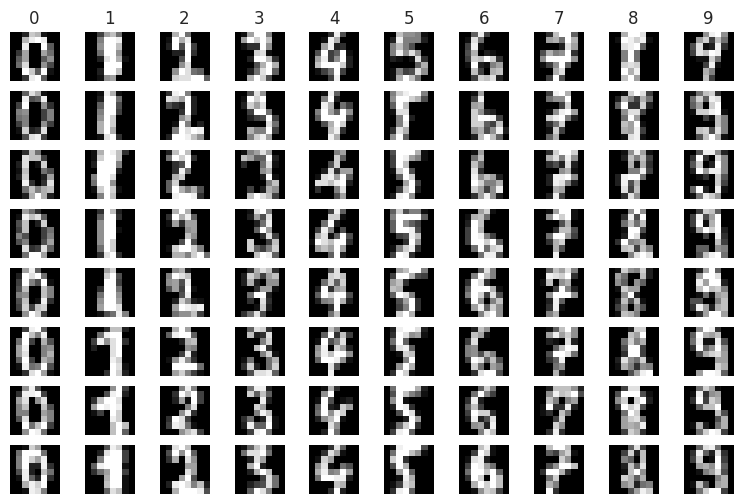

In [76]:
plot_digits(xs_train,ys_train)

**3.1.2** *Write a function to fit a polynomial kernel soft-margin SVM of degree $d$ to an $n \times 64$ dataset such as $\mathcal{D}_{\text{train}}$. Use the function to fit an SVM to $\mathcal{D}_{\text{train}}$. We will call this hypothesis $\hat{h}_1$, or `h_1`. You may refer to the `sklearn` [library](https://scikit-learn.org/stable/modules/classes.html) and tutorials.* $\color{red}{\text{(1 point)}}$

In [77]:
from sklearn.svm import SVC
def fit_SVM(xs,ys,d=1,C=0.5):
  """ Fits polynomial kernel soft-margin SVM to the supplied data
      xs = data vector of shape (num_samples, 64)
      ys = label vector of shape (num_samples,)
      d = polynomial degree
      C = cost
      output: h (the fitted model)
  """
  # YOUR CODE HERE
  h = SVC(kernel = 'poly', degree = d, C=C)
  h.fit(xs, ys)
  return h

In [78]:
h_1 = fit_SVM(xs_train,ys_train)

**3.1.3** *Write a function to make predictions using a fitted model $\hat{h}_1$ or on some dataset $\mathcal{D}$ or `xs, ys`. The function should return the predictions, the average loss $L(\hat{h}_1)$ using $\ell_{0-1}$, and the accuracy expressed as a percentage. You may again refer to the `sklearn` library.* $\color{red}{\text{(1 point)}}$

In [79]:
from sklearn.metrics import zero_one_loss
from sklearn.metrics import accuracy_score
def h_predict(h,xs,ys):
  """
  xs = data vector of shape (num_samples, 64)
  ys = label vector of shape (num_samples,)
  h  = the fitted model
  output:
  y_pred = prediction vector of shape (num_samples,)
  l01 = the zero-one loss
  acc = the accuracy expressed as a percentage
  """
  # YOUR CODE HERE
  ys_pred = h.predict(xs)
  l01 = zero_one_loss(ys, ys_pred)
  acc = accuracy_score(ys, ys_pred) * 100.0

  return ys_pred, l01, acc

**3.1.4** *How well did the model do? Do you notice any mistakes in its predictions? Report the empirical risk $R_\text{emp}(\hat{h}_1)$. Report the accuracy. Use `plot_digits` to plot a sampling of the predictions from your trained model.* $\color{red}{\text{(1 point)}}$



Empirical risk R(h_1): 0.100
Accuracy       h_1(xs_train): 90.000%


<Figure size 800x480 with 0 Axes>

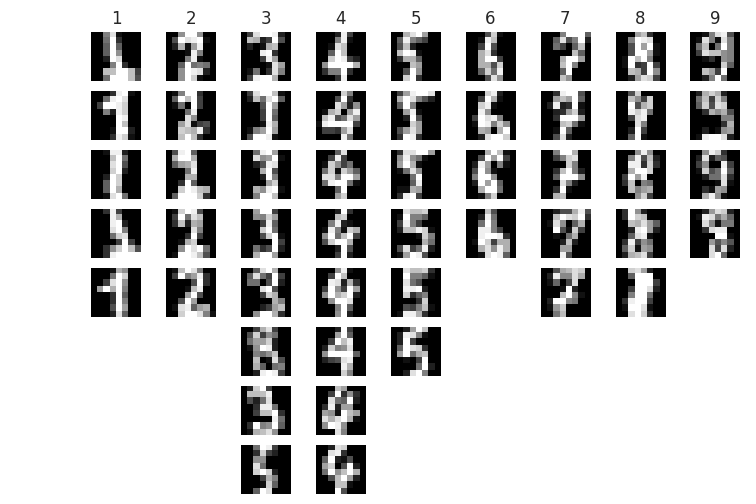

In [80]:
# YOUR CODE HERE

h = fit_SVM(xs_train, ys_train, d=3, C=0.5)
ys_pred, risk, acc = h_predict(h, xs_val, ys_val)

print("Empirical risk R(h_1): {:.3f}".format(risk))
print("Accuracy       h_1(xs_train): {:.3f}%".format(acc))

plot_digits(xs_val, ys_pred)

$\color{green}{\text{YOUR ANSWER HERE}}$

We think this model represents very well. Its empirical risk is 0.10, which means that the model fits the training data well and has a high accuracy.

**3.1.5** *Now, apply your model $\hat{h}_1$ on dataset $\mathcal{D}_{\text{test}}$. Make predictions, display the test error $L_\text{test}(\hat{h}_1)$  using $\ell_{0-1}$, the accuracy expressed as a percentage, and plot samples of your predictions in a figure.* $\color{red}{\text{(1 point)}}$

Zero-one loss h_1(xs_test): 0.120
Accuracy      h_1(xs_test): 88.000%


<Figure size 800x480 with 0 Axes>

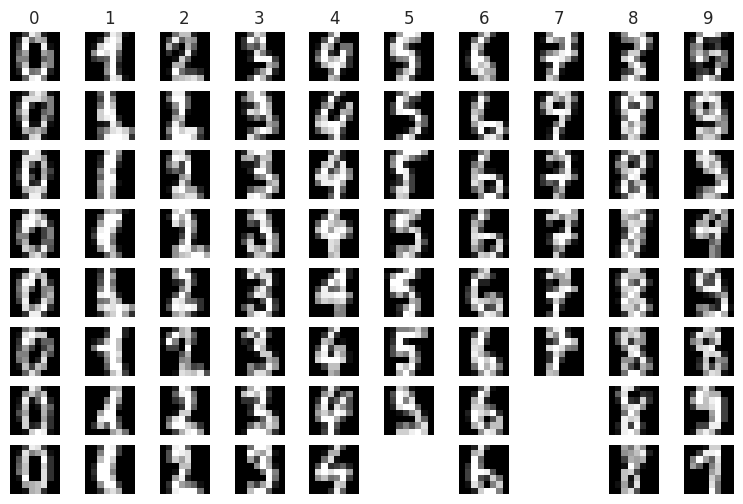

In [81]:
# YOUR CODE HERE
y_pred, L, acc = h_predict(h_1, xs_test, ys_test)

print("Zero-one loss h_1(xs_test): {:.3f}".format(L))
print("Accuracy      h_1(xs_test): {:.3f}%".format(acc))
plot_digits(xs_test, y_pred)

The results were not too bad, right? I wonder what would happen if we make our model more expressive. Let's give it a try.

**3.1.6** *Make your model more expressive by increasing the polynomial degree to $d=15$. Retrain your model on $\mathcal{D}_{\text{train}}$ and call it $\hat{h}_{15}$. Then report the Empirical Risk $R_{\text{emp}}$ and accuracy on the training set and plot samples of the predictions. Then apply $\hat{h}_{15}$ to the test set $\mathcal{D}_{\text{test}}$, make predictions, display the test error $L_\text{test}(\hat{h}_{15})$  using $\ell_{0-1}$, the accuracy expressed as a percentage, and plot samples of your predictions in a figure.* $\color{red}{\text{(1 point)}}$

Empirical risk R(h_15): 0.000
Accuracy       h_15(xs_train): 100.000%
Zero-one loss h_15(xs_test): 0.190
Accuracy      h_15(xs_test): 81.000%


<Figure size 800x480 with 0 Axes>

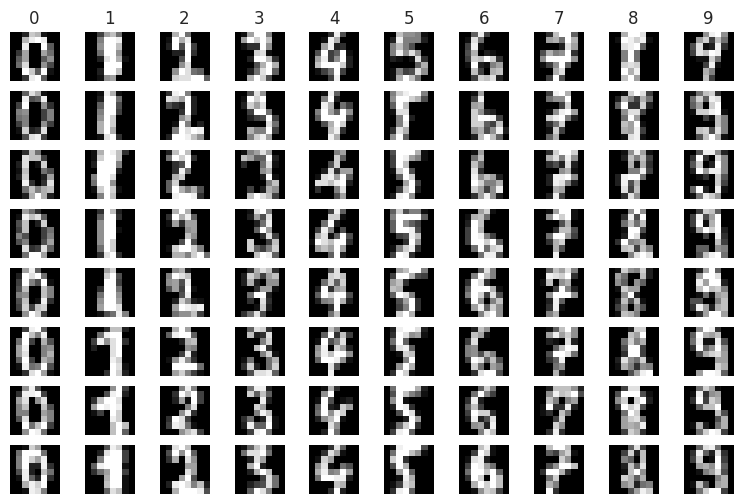

<Figure size 800x480 with 0 Axes>

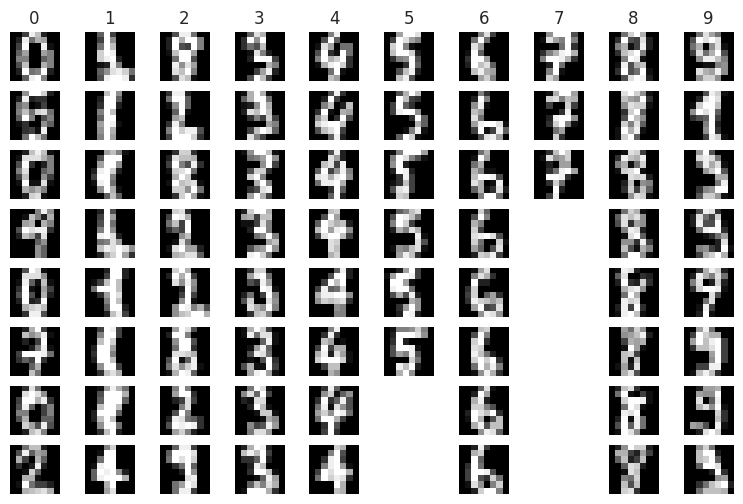

In [82]:
# YOUR CODE HERE
# h_15 = ...

h_15 = fit_SVM(xs_train, ys_train, d=15, C=0.5)
y_pred_train, risk, acc_train = h_predict(h_15, xs_train, ys_train)
print("Empirical risk R(h_15): {:.3f}".format(risk))
print("Accuracy       h_15(xs_train): {:.3f}%".format(acc_train))
plot_digits(xs_train, y_pred_train)

# YOUR CODE HERE
y_pred_test, L, acc_test = h_predict(h_15, xs_test, ys_test)
print("Zero-one loss h_15(xs_test): {:.3f}".format(L))
print("Accuracy      h_15(xs_test): {:.3f}%".format(acc_test))
plot_digits(xs_test, y_pred_test)

**3.1.7** *Explain what you observed in the previous step. Describe how these results can be explained by learning theory.* $\color{red}{\text{(1 point)}}$

$\color{green}{\text{YOUR ANSWER HERE}}$

In the previous step, we first increased d to 15 to increase the complexity of the model. At the same time, h_ 15 was recalculated and the train set was predicted. After calculating its empirical risk and accuracy, the prediction results are visualized. For the test set, it is the same operation, except that the calculation of empirical risk is replaced by the calculation of loss.

Model h_15 using larger d gets lower training error on the training set. This means it can better fit the training data. However, h_15 did not perform as well on the test set as on the training set because the model was too complex, resulting in overfitting of the training data.

**Ooops!** We just committed one of the worst sins in ML! You started playing around with hyperparameters and checking the results on the test set. Weren't we supposed to lock the test set in a chest and throw it into the ocean until we are done?

Very naughty. But seriously, don't try things out on the test set. We need it to be an impartial estimate of generalization.

Let's get our validation set $\mathcal{D}_{\text{val}}$ out and do things the right way.

**3.1.8** *Use the validation set to search for a good value for hyperparameter $d$, the polynomial degree. Search in the range $d = [0,20]$. Plot the training loss $L_{train}$ and validation loss $L_{val}$as a function of $d$. Report the best value for $d$ you find. Also plot and report the accuracy.* $\color{red}{\text{(2 points)}}$

best d =  4 with L_val =  0.09999999999999998  and acc =  70.0


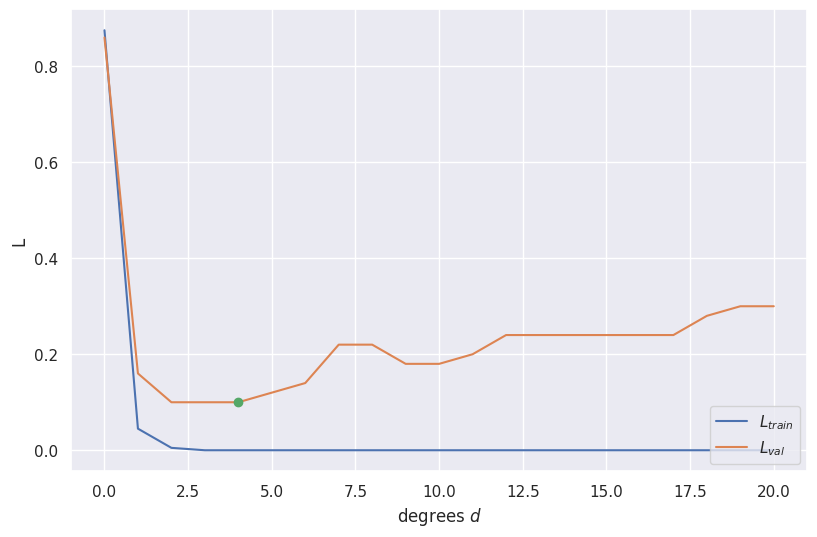

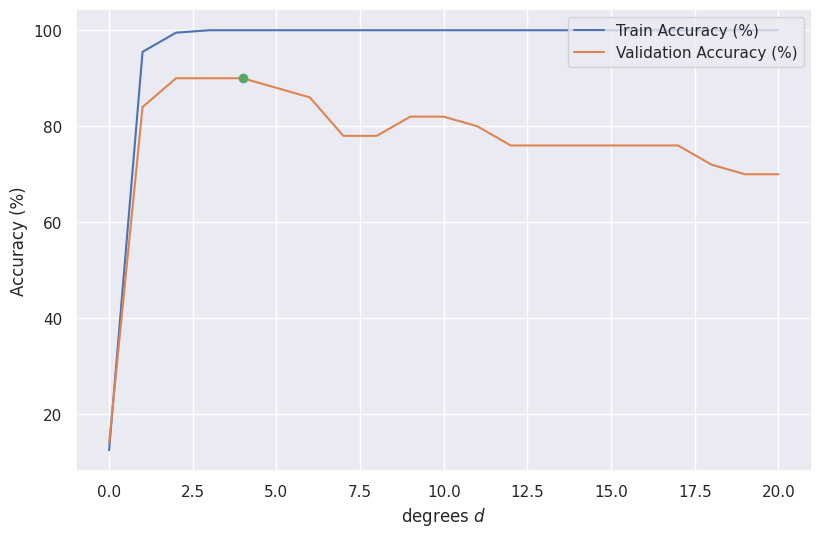

In [83]:
min_degree = 0
max_degree = 20
degrees = np.arange(min_degree, max_degree + 1, dtype=np.int64)

L_by_degree = {
    'train': np.zeros(shape=[max_degree - min_degree + 1]),
    'val': np.zeros(shape=[max_degree - min_degree + 1])
}
min_L = 100
best_d = 0
best_acc = 0
for d in degrees:
  # YOUR CODE HERE
  h = fit_SVM(xs_train, ys_train, d=d, C=0.5)
  _, loss_train, _ = h_predict(h, xs_train, ys_train)
  _, L, best_acc = h_predict(h, xs_val, ys_val)
  #L = min(loss_train, loss_val)
  L_by_degree['train'][d] = loss_train
  L_by_degree['val'][d] = L
  if L <= min_L:
    # YOUR CODE HERE
    best_d = d
    min_L = L
    #best_acc = acc


print('best d = ', best_d, 'with L_val = ', min_L, ' and acc = ', best_acc)

fig, ax = plt.subplots()
ax.plot(degrees, L_by_degree['train'], label=r"$L_{train}$")
ax.plot(degrees, L_by_degree['val'], label=r"$L_{val}$")
ax.set_xlabel('degrees $d$')
ax.set_ylabel('L')
ax.plot(best_d, min_L, 'o')
plt.legend(loc="lower right");

# YOUR CODE HERE
A_by_degree = {
    'train': np.zeros(shape=[max_degree - min_degree + 1]),
    'val': np.zeros(shape=[max_degree - min_degree + 1])
}
best_acc=0
for d in degrees:
  # YOUR CODE HERE
  h = fit_SVM(xs_train, ys_train, d=d, C=0.5)
  _, _, acc_train = h_predict(h, xs_train, ys_train)
  _, _, acc = h_predict(h, xs_val, ys_val)
  #L = min(loss_train, loss_val)
  A_by_degree['train'][d] = acc_train
  A_by_degree['val'][d] = acc
  if acc>=best_acc:
    best_acc = acc

# plot the accuracy here
fig, ax = plt.subplots()
ax.plot(degrees, A_by_degree['train'], label='Train Accuracy (%)')
ax.plot(degrees, A_by_degree['val'], label='Validation Accuracy (%)')
ax.set_xlabel('degrees $d$')
ax.set_ylabel('Accuracy (%)')
ax.plot(best_d, best_acc, 'o')
plt.legend(loc="upper right")


Great! It seems we've found a good value for the hyperparameter $d$, the polynomial degree. What if we change the regularization weight to help constrain the expressiveness of the hypothesis?

Recall that for the **SVM** model specifically, we have two objectives:
1. Find a hyperplane (i.e. decision boundary) that maximises the number of samples that are classified correctly - this is the loss term
2. Find a hyperplane that maximises the **thickness of the margin** between the samples from the respective classes - this is the regularization term

The term $C$ in an SVM controls the relative strength of the regularization term and the loss term. **Low** values of $C$ will force the algorithm to find a **larger** margin, typically at the cost of not being able to classify all samples correctly. Conversely, **large** values of $C$ will force the algorithm to find a hyperplane that leads to a **higher** accuracy, typically at the expense of a **thinner** margin. Consequently, there is a **sweet spot** when it comes to optimising $C$. Let's do a *grid search* to find good values for $d$ and $C$ simultaneously!

<br>

**3.1.9** *Use the validation set to search for values for hyperparameters $d$ and $C$. Search in the range $d = [0,20]$, $C=\{10^{-5}, 10^{-4.5}, \ldots, 10^1\}$. Use the code below to make a contour plot of the validation loss $L_{val}$ as a function of $d$ and $C$. Report the best values for $d$ and $C$ you find.* $\color{red}{\text{(2 points)}}$

best d =  2 best C =  1.0 with L_val =  0.07999999999999996


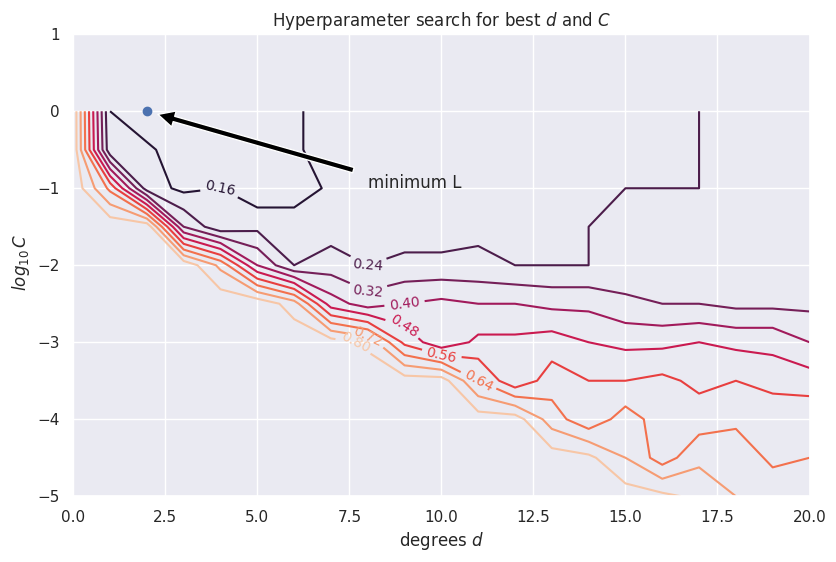

In [84]:
degrees = np.arange(min_degree, max_degree + 1, dtype=np.int64)
Cs_exp = np.arange(-5, 0.5, 0.5, dtype=float)
Cs = 10.0**Cs_exp
L_by_C_by_degree = np.zeros(shape=[len(Cs), len(degrees)])

min_L = 100 # we arbitrarily set 100 here since it is a large number
best_d = 0
best_C = 0
for C_id, C in enumerate(Cs):
  for degree_id, degree in enumerate(degrees):
    # YOUR CODE HERE
    h = fit_SVM(xs_train, ys_train, d=degree, C=C)
    _, loss_val, _ = h_predict(h, xs_val, ys_val)
    L_by_C_by_degree[C_id, degree_id] = loss_val
    if loss_val <= min_L:
      best_d = degree
      best_C = C
      min_L = loss_val


print('best d = ', best_d, 'best C = ', best_C, 'with L_val = ', min_L)
fig, ax = plt.subplots()
CS = ax.contour(degrees, Cs_exp, L_by_C_by_degree, 10)
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('Hyperparameter search for best $d$ and $C$')
ax.set_xlabel('degrees $d$')
ax.set_ylabel(' $log_{10} \, C$')
ax.axis([0, 20, -5, 1])
ax.plot(best_d, np.log10(best_C), 'o')
ax.annotate('minimum L', xy=(best_d, np.log10(best_C)), xytext=(8, -1),
            arrowprops=dict(facecolor='black', shrink=0.05));

That looks like a pretty good model. Let's lock down that model. Since we are finished developing the model, **now** we apply it on the test set to see how it performs.

**3.1.10** *Apply your final model to the test set to estimate how it generalizes. Report the test loss $L_{test}$ and accuracy. Plot some samples of the clasification results. Comment on the results you see and compare it to when you peeked at the test set earlier on.* $\color{red}{\text{(1 point)}}$

Zero-one loss h_15(xs_test): 0.190
Accuracy      h_15(xs_test): 81.000%


<Figure size 800x480 with 0 Axes>

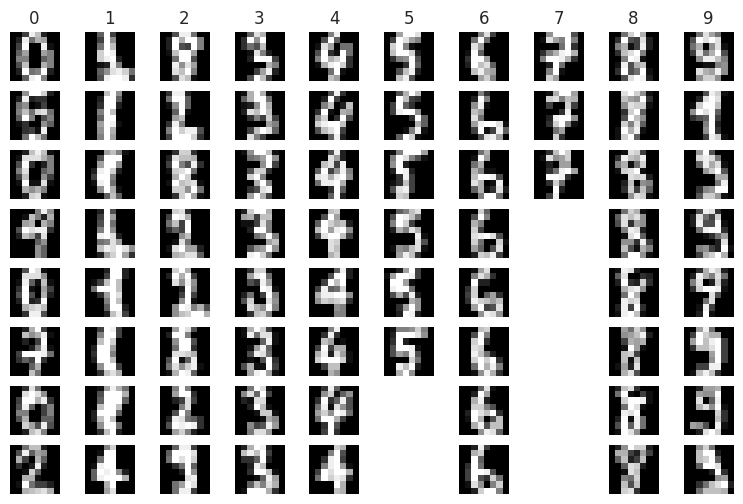

In [85]:
# YOUR CODE HERE

y_pred, L, acc = h_predict(h_15, xs_test, ys_test)

print("Zero-one loss h_15(xs_test): {:.3f}".format(L))
print("Accuracy      h_15(xs_test): {:.3f}%".format(acc))

plot_digits(xs_test, y_pred)

$\color{green}{\text{YOUR ANSWER HERE}}$

Comparing the two results, it is found that the performance of the model on the test set remains consistent without very obvious changes, which means that the generalization ability of the model on the test set is relatively stable.

To wrap up this part of the exercise, I am going to shift the digits to the right in the test set a bit. We will call this new set $\mathcal{D}_{\text{domain_shift}}$ or `xs_ds` and `ys_ds`.

In [86]:
xs_ds = xs_test.reshape((-1,8,8))
ys_ds = ys_test
for i in np.arange(1,100):
  xs_ds[i,:,:] = np.roll(xs_ds[i,:,:], 1)
xs_ds = np.reshape(xs_ds, newshape=[-1, 8 * 8])

**3.1.11** *Apply your final model to $\mathcal{D}_{\text{domain_shift}}$ to estimate how it generalizes there. Report the test loss $L_{test}$ and accuracy. Plot some samples of the clasification results `plot_digits`. Comment on the results you see and compare it to your previous results. Explain why the results appear as they do.* $\color{red}{\text{(1 point)}}$

$\color{green}{\text{YOUR ANSWER HERE}}$

The loss of this model is 0.66 and the accuracy is 0.34. It can be seen that its accuracy is not high, especially when compared with the previous model.

Zero-one loss h_15(xs_test): 0.660
Accuracy      h_15(xs_test): 34.000%


<Figure size 800x480 with 0 Axes>

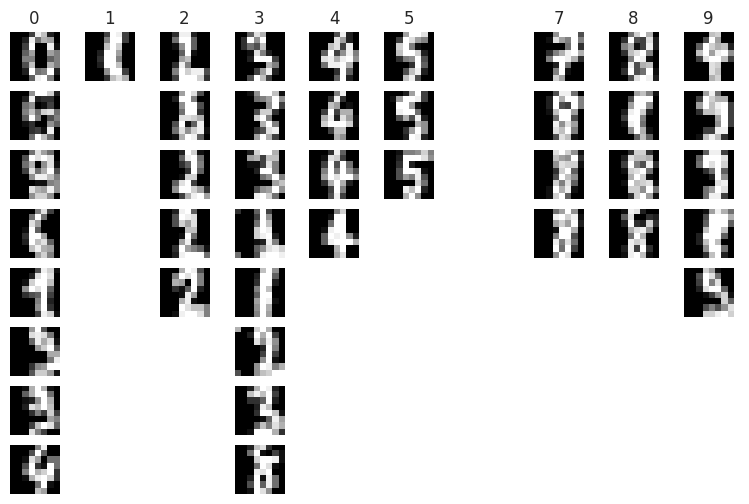

In [87]:
y_pred, L, acc = h_predict(h_15, xs_ds, ys_ds)

print("Zero-one loss h_15(xs_test): {:.3f}".format(L))
print("Accuracy      h_15(xs_test): {:.3f}%".format(acc))

plot_digits(xs_test, y_pred)

# 3.2 Bayes Optimial Hypothesis (3 points)

In the Lecture Notes, we relied on an expression for the Bayes optimal hypothesis, $h_{bayes}^\text{square}$, in the bias-variance decomposition of the $\ell_{square}$ loss.

<br>

$$
\begin{align}
h_{bayes}^\text{square} (x) &= \arg \min_{h} \mathbb{E}_{ \mathcal{P}_{\pmb{y}|\pmb{x}}} [ \, \ell_{square}   (h(x), \pmb{y})  \,] \\
h_{bayes}^\text{square} (x) &= \arg \min_{h} \mathbb{E}_{ \mathcal{P}_{\pmb{y}|\pmb{x}}} [ (h(x) - \pmb{y} )^2 ] \\
 &= \arg \min_{\hat{{y}}} \mathbb{E}_{ \mathcal{P}_{\pmb{y}|\pmb{x}}} [ (\hat{y} - \pmb{y} )^2 ]
\end{align}
$$



**3.2.1** *Starting from the expression above, show that*

$$
h_{bayes}^\text{square} = \mathbb{E}_{\mathcal{P}_{y|\pmb{x}}} [\pmb{y}]
$$

<br>

*Hint: rewrite using the definition of the expectation first, then take derivative w.r.t.* $\hat{y}$. $\color{red}{\text{(3 points)}}$


$\color{green}{\text{YOUR ANSWER HERE}}$

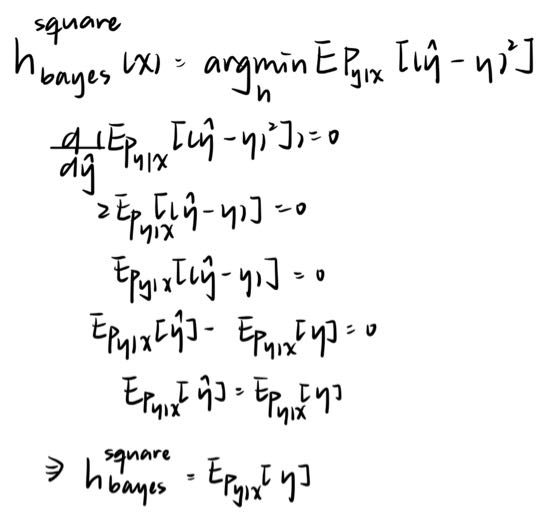

# 3.3 Generalization using Cross Validation (5 points + 2 bonus points)

There are a number of shortcomings of estimating the test error a single time as we did above in 3.1. For example, if the dataset is small, we would like to use the entire dataset to estimate the test error (as well as to train the model). Also, if we are interested in statistical properties of the test error, *e.g.* the mean, standard deviation, or confidence interval, we lack the means to obtain these statistics. We might want to calculate these statistics in order to show that one model is superior over another.

A (partial) solution to this dilemma is called **cross validation**. The basic idea is to divide the data into equal partitions and iterate over the partitions, each time using one partition as the test set and the others for training. Suppose that our dataset is given by $D = \lbrace (x_i, y_i)\rbrace_{i=1}^n$. A vanilla version of cross validation is $K$-fold cross validation in which we do the following:
1. Pick $K$ (e.g. $K=5$)
2. Shuffle $D$
3. Divide $D$ into $K$ non-overlapping subsets $D_1, \ldots, D_K$ by letting $D_1$ have the first $\frac{n}{K}$ indices of $D$, $D_2$ the next $\frac{n}{K}$ of $D$ etc.
4. For each $k = 1, \ldots, K$, train the model on the **union** of all $D_i$ for $i \neq k$ and report it's quality on $D_k$.

Let's load digit images from MNIST again. This time we will use $1,000$ examples.

In [88]:
from sklearn.datasets import load_digits
data = load_digits()
imgs = data['images'] # shape (1797, 8, 8)
targets = data['target'] # shape (1797,)

n = 1000
xall = np.reshape(imgs, newshape=[-1, 8 * 8]) # shape (1797, 64)
yall = targets # shape (1797,)

ix = np.arange(1000)
xs = xall[ix] # shape (n, 64)
ys = yall[ix] # shape (n,)

**3.3.1.** *Create a function ```generate_folds``` that returns $K$ sets of non-overlapping indices. To make the sets have equal length, you should discard the remainder of the data.*  $\color{red}{\text{(1 point)}}$

In [89]:
def generate_folds(ys: np.ndarray, K: int):
    """
    Generates 'K' folds (indices). If 'N' is not divisible by 'K' the remainder of the data is discarded.
    Input:
        ys: An np.ndarray of shape [N]
    Returns:
        ix: An np.ndarray of shape [K, N // K] containing the indices of each fold
    """

    assert K > 0, "K needs to be positive!"

    N = len(ys)
    ordered_index = [i for i in range(N)]
    num = N//K
    ys_rand = np.random.permutation(ordered_index)
    ix = np.array([ys_rand[i*num:(i+1)*num] for i in range(K)])
    return ix

**3.3.2.** *Write a loop over $k=1, \ldots, K$ for $K=5$ that performs $K$-fold cross validation. Use SK-Learn's implementation of a soft-margin SVM with an* RBF Kernel, *and otherwise default parameters. Compute and report the accuracy for each fold $k$ along with the mean accuracy and the standard deviation.*  $\color{red}{\text{(1 point)}}$

In [90]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

K = 5
accuracy_on_fold = np.zeros(shape=[K])

# YOUR CODE HERE
#model = SVC(kernal="rbf")
ix = generate_folds(ys, K)
for i in range(K):
  model = SVC(kernel="rbf")
  train_indexes = [index for j, sublist in enumerate(ix) if j!=i for index in sublist]
  xs_val, ys_val = [xs[k] for k in ix[i]], [ys[k] for k in ix[i]]
  xs_train, ys_train = [xs[k] for k in train_indexes], [ys[k] for k in train_indexes]
  model.fit(xs_train, ys_train)
  ys_pred = model.predict(xs_val)
  accuracy_on_fold[i] = accuracy_score(ys_val, ys_pred)

print(f"{accuracy_on_fold.mean()} {K}-fold CV accuracy")
print(f"{accuracy_on_fold.std()} {K}-fold CV accuracy")

0.9870000000000001 5-fold CV accuracy
0.006782329983125275 5-fold CV accuracy


Using our new knowledge on cross validation, let's now find and optimal value of $C$ for our RBF kernel SVM.

**3.3.3.** Perform $K$-fold cross validation for $K=5$, and in each fold loop over $C=0.1, 0.2, \ldots, 5.0$. Thus, you will have nested loops for $k=1, \ldots, K$ for $K=5$ (outer) and $C=0.1, 0.2, \ldots, 5.0$ (inner).
For each fold $k$, use SK-Learn's **SVM** implementation and compute the `accuracy_per_fold` for each $C$. Then, compute the mean and standard deviations of `accuracy_per_fold` over the folds. Use the code provided below to print the best mean accuracy and corresponding standard deviation, along with a plot of all accuracies and standard deviations.*  $\color{red}{\text{(2 points)}}$

99.000 best mean 5-fold CV accuracy at C=1.600
0.003 5-fold CV standard deviation at C=1.600


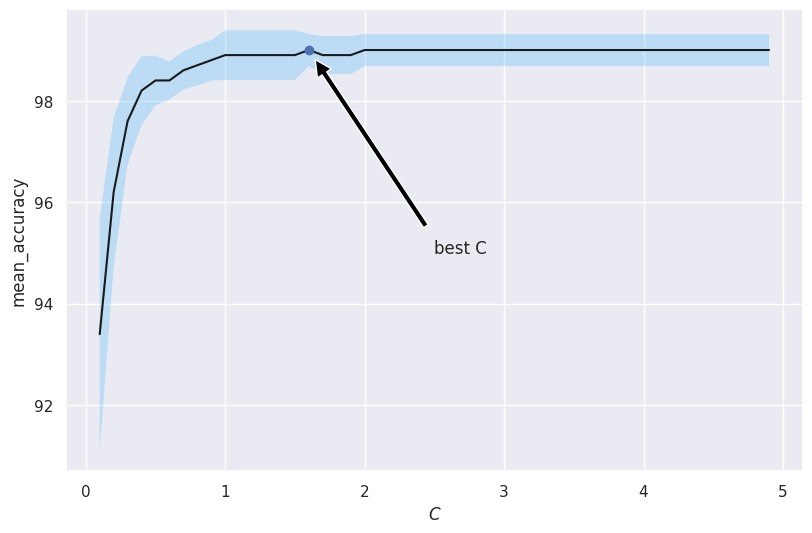

In [91]:
K = 5
Cs = np.arange(0.1, 5.0, 0.1)
accuracy_per_fold = np.zeros(shape=[len(Cs), K])

# YOUR CODE HERE
ix = generate_folds(ys, K)
for i in range(K):
  for c_i, c in enumerate(Cs):
    model = SVC(kernel="rbf", C=c)
    train_indexes = [index for j, sublist in enumerate(ix) if j!=i for index in sublist]
    xs_val, ys_val = [xs[k] for k in ix[i]], [ys[k] for k in ix[i]]
    xs_train, ys_train = [xs[k] for k in train_indexes], [ys[k] for k in train_indexes]
    model.fit(xs_train, ys_train)
    ys_pred = model.predict(xs_val)
    accuracy_per_fold[int(c*10.1-1)][i] = accuracy_score(ys_val, ys_pred) #the 10.1 is ugly, but that's what it has to be ;)
    #print(int(c*10.1-1))
    #if accuracy_per_fold[int(c*10-1)][i]<0.001:
      #print("ha? "+ str(c))

mean_accuracy = np.mean(accuracy_per_fold, axis=1)
stdev = np.std(accuracy_per_fold, axis=1)

# YOUR CODE HERE
best_C = np.argmax(mean_accuracy)
best_acc = mean_accuracy[best_C]*100
best_stdev = stdev[best_C]
best_C=(best_C+1)/10
mean_accuracy*=100
stdev*=100
#print(mean_accuracy)

# provided printing and plotting
assert mean_accuracy.shape == (49,)
assert stdev.shape == (49,)
print(f"{best_acc.item():.3f} best mean {K}-fold CV accuracy at C={best_C.item():.3f}")
print(f"{best_stdev.item():.3f} {K}-fold CV standard deviation at C={best_C.item():.3f}")
fig, ax = plt.subplots()
ax.plot(Cs, mean_accuracy, 'k-')
ax.fill_between(Cs, mean_accuracy-stdev, mean_accuracy+stdev,
    alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
    linewidth=0, linestyle='dashdot', antialiased=True);
ax.plot(best_C, best_acc, 'o')
ax.annotate('best C', xy=(best_C, best_acc), xytext=(2.5, 95), arrowprops=dict(facecolor='black', shrink=0.05))
ax.set_xlabel('$C$')
ax.set_ylabel('mean_accuracy');

**Oh no!** You didn't do it again, did you? You weren't using test splits to choose $C$, were you? I hope those were validation folds! I'll give you the benefit of the doubt and assume they were validation folds.

<br>

If you want to use cross validation to both do model selection *and* to assess generalization, you need to use **nested cross validation** which nests a validation loop inside each test loop. We won't do that here, because luckily, there we still have some data samples we never used (we used $1,000$ of the $1,797$ in total), and this can serve as our test set $\mathcal{D}_{test}$.

In [92]:
ix = np.arange(1000,1797)
xs_test = xall[ix]
ys_test = yall[ix]

Now, apply the best model you found on the test set to estimate the generalizaiton accuracy.

**3.3.4.** *Apply the best model you found in 3.3.3 on the test set and report the accuracy.*  $\color{red}{\text{(1 points)}}$

In [93]:
# YOUR CODE HERE
model = SVC(kernel="rbf", C=best_C)
model.fit(xs,ys)
ys_test_pred = model.predict(xs_test)
accuracy = accuracy_score(ys_test, ys_test_pred)
print(f" {accuracy:.3f} accuracy on test set")

 0.965 accuracy on test set


In practice, it is often beneficial to use a **stratified** variant of cross validation. Suppose that we have $K$ classes and each class $i$ occurs with frequency $\omega_i = \frac{n_i}{n}$ where $n_i = |\lbrace j | y_j = i \rbrace|$ is the count of examples in class $i$. Building the folds as we did before, it can happen that some fold $D_k$ doesn't feature the same class frequencies as the whole dataset $D$. This, in turn, can lead to poor estimations.

**Stratification** means that we attempt to sample the folds in such a way that the class frequencies are roughly the same as they are on the whole dataset. Let's plot the **class frequencies** of the digits dataset:

<Axes: >

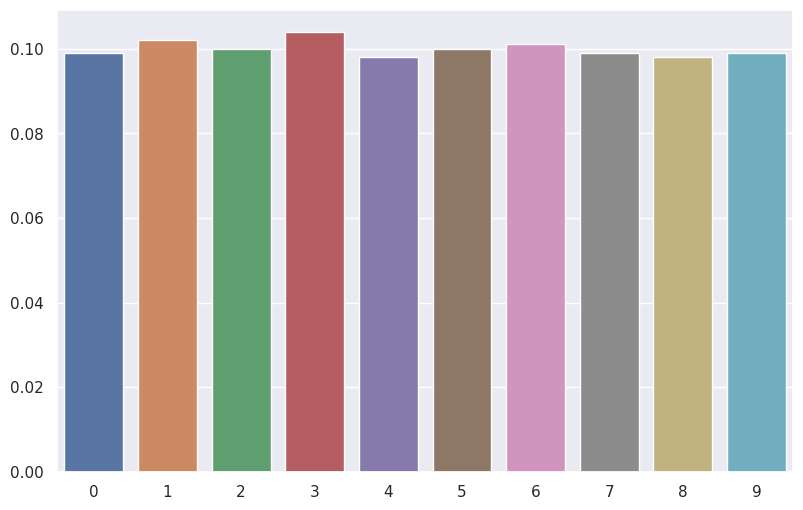

In [94]:
class_labels, class_counts = np.unique(ys, return_counts=True)
class_freqs = class_counts/n
sns.barplot(x=class_labels, y=class_freqs)

Let's repeat what we did before. For each fold we pick $\frac{n}{K}$ samples uniformly at random from the dataset without replacement. How even are the distributions across the folds?

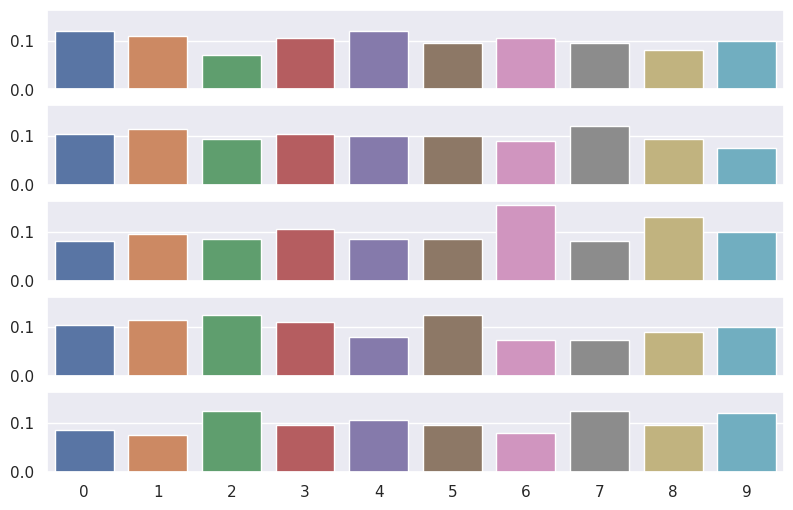

In [95]:
K = 5

# shuffle the data
ix = np.random.choice(len(xs), size=n, replace=False)
xs = xs[ix] # shape (n, 64)
ys = ys[ix] # shape (n,)

# generate fold indexes
folds_ix = generate_folds(ys, K=K)

# plot the frequencies
fig, ax = plt.subplots(nrows=K, ncols=1, sharex=True, sharey=True)
for i, fold_ix in enumerate(folds_ix):
    class_labels_fold, class_counts_fold = np.unique(ys[fold_ix], return_counts=True)
    class_freqs_fold = class_counts_fold/class_counts_fold.sum()
    sns.barplot(x=class_labels_fold, y=class_freqs_fold, ax=ax[i])

It looks like some of the folds are a bit unbalanced, huh? A solution would ensure that each fold has the same distribution.

**3.3.5.** *Write the function ```generate_folds_by_stratification``` that generates folds with stratified sampling.*  $\color{blue}{\text{(2 bonus points)}}$

In [96]:
def generate_folds_by_stratification(ys: np.ndarray, K: int):
    """
    Generates 'K' folds (indices) by stratification. Each fold is guaranteed to have the same label distribution.
    If 'n' is not divisible by 'K' the remainder of the data is discarded.
    Input:
        ys: An np.ndarray of shape [n]
    Returns:
        An np.ndarray of shape [K, n // K] containing the indices of each fold
    """

    assert K > 0, "K needs to be positive!"

    # YOUR CODE HERE
    class_labels, unique_inverse, class_counts = np.unique(ys, return_counts=True, return_inverse=True)
    class_K_step = class_counts // K
    class_freqs = class_counts/n
    K_indexes=[np.random.permutation([i for i in range(len(ys)) if ys[i]==j]) for j in range(len(class_labels))]
    ix=[]
    for i in range(K):
      ix.append([])
      for label in class_labels:
        #print(class_K_step[label])
        #print(K_indexes[label][i*class_K_step[label]: (i+1)*class_K_step[label]])
        ix[i].extend(K_indexes[label][i*class_K_step[label]: (i+1)*class_K_step[label]])

    #print(K_indexes)
    ix = np.array(ix, dtype="int64")

    return np.asarray(ix)

Let us visualize the label distribution of the individual folds using stratified sampling with `generate_folds_by_stratification`:

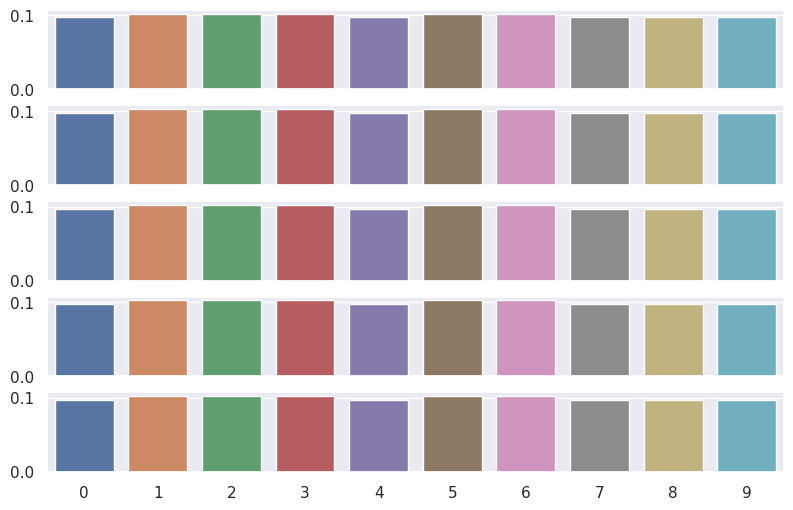

In [97]:
K = 5
folds_ix = generate_folds_by_stratification(ys, K=K)

fig, ax = plt.subplots(nrows=K, ncols=1, sharex=True, sharey=True)
for i, fold_ix in enumerate(folds_ix):
    class_labels_fold, class_counts_fold = np.unique(ys[fold_ix], return_counts=True)
    class_freqs_fold = class_counts_fold/class_counts_fold.sum()
    sns.barplot(x=class_labels_fold, y=class_freqs_fold, ax=ax[i])

# 3.4 Performance metrics (2 points)


In this section we are going to ask you to implement some of the most important performance metrics in ML. In order to make things as simple as possible, we will first convert our earlier multi-class problem to a binary one.

In [98]:
from sklearn.datasets import load_digits
from matplotlib import pyplot as plt
data = load_digits()
imgs = data['images'] # shape (1797, 8, 8)
targets = data['target'] # shape (1797,)

Here we just randomly decided to classify only the digits 8 and 9.

In [99]:
binary_samples = np.logical_or(targets==8, targets==9)
imgs = imgs[binary_samples]
targets = targets[binary_samples]-8

Next, we split the data into two partitions. We will train a model with preset hyperparameters later so we do not need a validation set in this instance. Consider what we are doing here for a moment. Is it ok to not have a validation set?

In [100]:
num_samples = 350
xs = np.reshape(imgs, newshape=[-1, 8 * 8]) # shape (1797, 64)
ys = targets # shape (1797,)
ix = np.random.choice(len(xs), size=num_samples, replace=False)
xs = xs[ix] # shape (num_samples, 64)
ys = ys[ix] # shape (num_samples,)

In [101]:
np.random.seed(1)
X, Y = split_into_subsets(X=xs, Y=ys, sizes=(100.0, 250.0))
xs_test = X[0]
ys_test = Y[0]
xs_train = X[1]
ys_train = Y[1]
print('shape of xs_train ', xs_train.shape, '  shape of ys_train ', ys_train.shape, '\nshape of xs_test  ', xs_test.shape, '  shape of ys_test  ', ys_test.shape)

shape of xs_train  (250, 64)   shape of ys_train  (250,) 
shape of xs_test   (100, 64)   shape of ys_test   (100,)


We also apply a slight domain shift as we did previously.

In [102]:
xs_ds = xs_test.reshape((-1,8,8))
ys_ds = ys_test
for i in np.arange(1,100):
  xs_ds[i,:,:] = np.roll(xs_ds[i,:,:], 1)
xs_ds = np.reshape(xs_ds, newshape=[-1, 8 * 8])

Finally we train a logistic regression classifier with some fixed parameters. You can also try to train your own implementation from Exercise 2 here.

In [103]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, max_iter=100, tol=1e-2).fit(xs_train, ys_train)

Here is a way to report the accuracy of this set of predictions. Later, we are going to ask you to implement a similar function.

In [104]:
accuracy = clf.score(xs_test, ys_test)
print(f"Accuracy of this binary classifier is {accuracy*100}%.")

Accuracy of this binary classifier is 81.0%.


Similarly, we compute the precision, recall and confusion matrix for this set of predictions using ```sklearn``` again.

In [105]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix

In [106]:
predictions = clf.predict(xs_test)
CM = confusion_matrix(ys_test, predictions)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
print(f"The number of true positives is {TP}, true negatives is {TN}, false positives is {FP} and false negatives is {FN}.")

The number of true positives is 41, true negatives is 40, false positives is 18 and false negatives is 1.


And here is one way to visualize the confusion matrix:

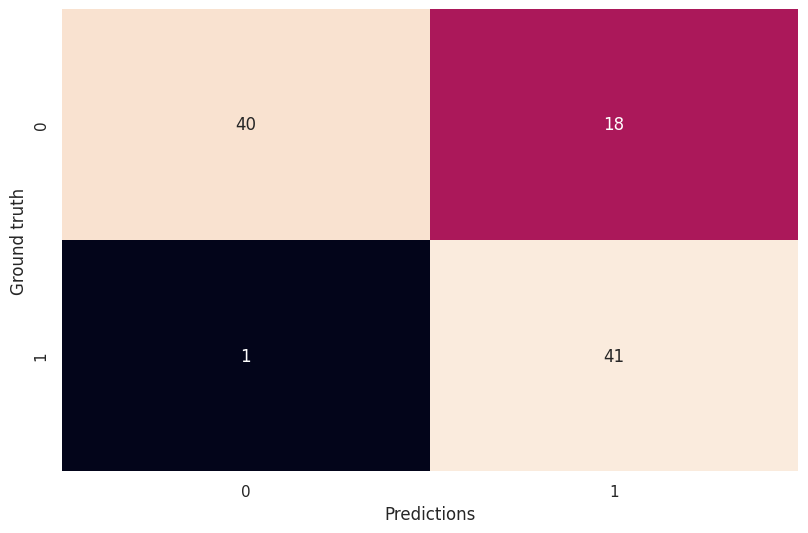

In [107]:
s = sns.heatmap(CM, annot=True, cbar=False)
s.set(ylabel='Ground truth', xlabel='Predictions');

In [108]:
precision = precision_score(ys_test, predictions)
recall = recall_score(ys_test, predictions)
print(f"The precision of the classifier is {precision} and its recall is {recall}.")

The precision of the classifier is 0.6949152542372882 and its recall is 0.9761904761904762.


Now, you will get to implement these metrics for yourself.

### Accuracy
**3.4.1.** *Write the function ```get_accuracy``` that calculates the accuracy of a prediction given the ground truth. In previous steps we had imported ```accuracy_score``` function from sklearn to do this, now you are implementing that for yourself.*  $\color{red}{\text{(0.5 points)}}$

In [109]:
def get_accuracy(y_true, y_pred):
  count=0
  assert len(y_true)==len(y_pred)
  for i in range(len(y_true)):
    if y_true[i]==y_pred[i]:
      count+=1
  acc = count/len(y_true)
  # YOUR CODE HERE
  return acc
predictions = clf.predict(xs_test)
print(f"Accuracy of the prediction is {get_accuracy(ys_test, predictions)*100}%.")

Accuracy of the prediction is 81.0%.


### Confusion matrix
**3.4.2.** *Write the function ```get_cm``` that computes the TN, FN, TP, FP counts and returns them as a [binary confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). We have already seen a confusion matrix in the lecture notes. What the axes represent is just a convention and here we opt for sklearn's convention like we did above.*  $\color{red}{\text{(1 points)}}$

In [110]:
def get_cm(y_true, y_pred):
  # YOUR CODE HERE
  #print(y_true)
  #print(y_pred)
  TP=0
  TN=0
  FP=0
  FN=0
  for i in range(len(y_true)):
    if y_true[i]==1 and y_pred[i]==1:
      TP+=1
    if y_true[i]==1 and y_pred[i]==0:
      FN+=1
    if y_true[i]==0 and y_pred[i]==1:
      FP+=1
    if y_true[i]==0 and y_pred[i]==0:
      TN+=1
  cm=[[TN,FP],[FN,TP]]
  return cm

And next you can run and visualize your solution

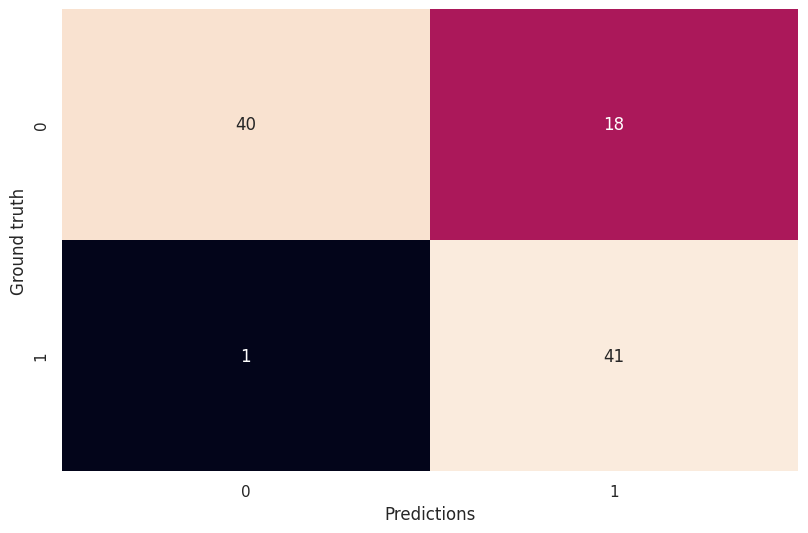

In [111]:
cm = get_cm(ys_test, predictions)
assert np.all(cm == CM)
s = sns.heatmap(cm, annot=True, cbar=False)
s.set(ylabel='Ground truth', xlabel='Predictions');

### Precision and recall
_Precision_ measures the fraction of positive classifications that are correct (that actually are true positives). Precision is useful when the cost of false positives is high, e.g. you have built a medical screening test for local *vårdcentral*s and each false positive means someone will have to go through an expensive and painful biopsy.

The recall measures the fraction of the true positives that are correctly classified by our classifier. It is also called the _True Positive Rate (TPR)_ or the _sensitivity_. Recall is important when missing *true* samples is costly, e.g. you have built a diagnostic test for Karolinska Hospital and each false negative means someone might die.

**Task 3.4.3:** *Write the function ```get_precision_recall``` that computes the precision and recall given the predictions and the true labels. You can and should use your ```get_cm``` function here.* $\color{red}{\text{(0.5 points)}}$

In [112]:
def get_precision_recall(y_true, y_pred):
    # YOUR CODE HERE
    cm=get_cm(y_true, y_pred)
    precision = cm[1][1]/(cm[1][1]+cm[0][1]) if cm[1][1]+cm[0][1] > 0 else 0.0
    recall = cm[1][1]/(cm[1][1]+cm[1][0]) if cm[1][1]+cm[0][1] > 0 else 0.0
    return precision, recall

In [113]:
precision, recall = get_precision_recall(ys_test, predictions)
assert precision_score(ys_test, predictions) == precision
assert recall_score(ys_test, predictions) == recall
print(f"The precision of the classifier is {precision} and its recall is {recall}.")

The precision of the classifier is 0.6949152542372882 and its recall is 0.9761904761904762.
